# <center> Домашнее задание № 9. (демо). Решение
## <center> Анализ временных рядов
    
**Заполните пропущенный код и ответьте на вопросы в [онлайн-форме](https://docs.google.com/forms/d/1ijk4aFKY5plPiI8z3Mgi3i1Ln94VBY9SSt6xGIdVVFQ/).**

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd


from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests
import pandas as pd

print(__version__) # need 1.9.0 or greater

init_notebook_mode(connected = True)


def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

2.7.0


## Подготавливаем данные

In [2]:
df = pd.read_csv('../../data/wiki_machine_learning.csv', sep = ' ')
df = df[df['count'] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [3]:
df.shape

(383, 7)

## Предсказываем с помощью FB Prophet
Будем обучаться на первых 5 месяцах и предсказывать число поездок за июнь.

In [4]:
df.date = pd.to_datetime(df.date)

In [5]:
plotly_df(df.set_index('date')[['count']])

In [6]:
from fbprophet import Prophet

In [7]:
predictions = 30

df = df[['date', 'count']]
df.columns = ['ds', 'y']
df.tail()

,ds,y
382,2016-01-16,1644
381,2016-01-17,1836
376,2016-01-18,2983
375,2016-01-19,3389
372,2016-01-20,3559


In [8]:
train_df = df[:-predictions].copy()

In [9]:
m = Prophet()
m.fit(train_df);

In [10]:
future = m.make_future_dataframe(periods=predictions)
future.tail()

,ds
378,2016-01-16
379,2016-01-17
380,2016-01-18
381,2016-01-19
382,2016-01-20


In [11]:
forecast = m.predict(future)
forecast.tail()

,ds,t,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,seasonal_lower,seasonal_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,seasonal,yhat
378,2016-01-16,1.073446,2946.091778,2112.348172,2877.361402,2946.091772,2946.091785,-460.818755,-460.818755,-860.484941,-860.484941,-860.484941,399.666186,399.666186,399.666186,-460.818755,2485.273023
379,2016-01-17,1.076271,2949.096324,2278.126783,3000.439378,2949.096317,2949.096331,-303.307624,-303.307624,-720.184556,-720.184556,-720.184556,416.876932,416.876932,416.876932,-303.307624,2645.788700
380,2016-01-18,1.079096,2952.100870,3314.428247,4034.205685,2952.100863,2952.100878,714.117189,714.117189,282.582855,282.582855,282.582855,431.534334,431.534334,431.534334,714.117189,3666.218059
381,2016-01-19,1.081921,2955.105416,3593.954755,4307.752013,2955.105409,2955.105424,981.619602,981.619602,538.093426,538.093426,538.093426,443.526177,443.526177,443.526177,981.619602,3936.725019
382,2016-01-20,1.084746,2958.109962,3496.580291,4183.402108,2958.109954,2958.109971,874.491161,874.491161,421.712240,421.712240,421.712240,452.778920,452.778920,452.778920,874.491161,3832.601123


**Вопрос 1:** Какое предсказание числа просмотров wiki-страницы на 20 января? Ответ округлите до целого числа.

**Ответ:** 3833

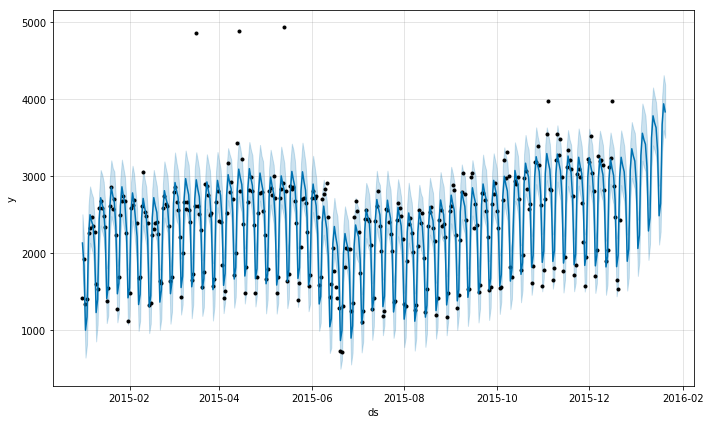

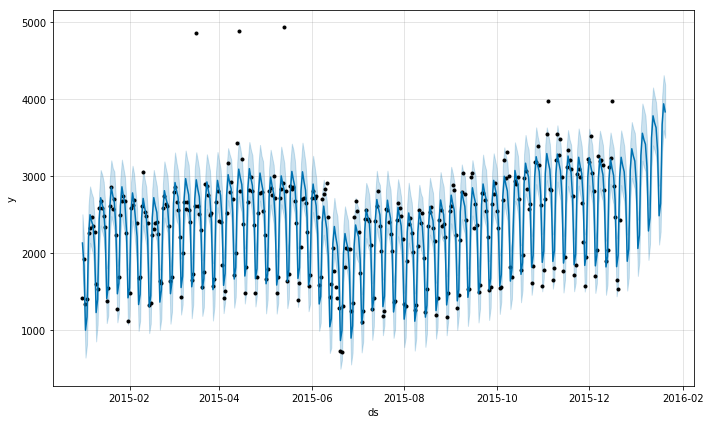

In [12]:
m.plot(forecast)

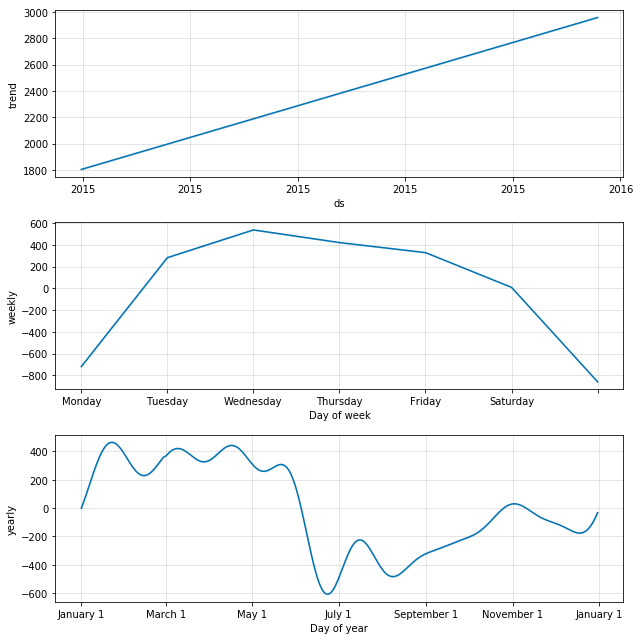

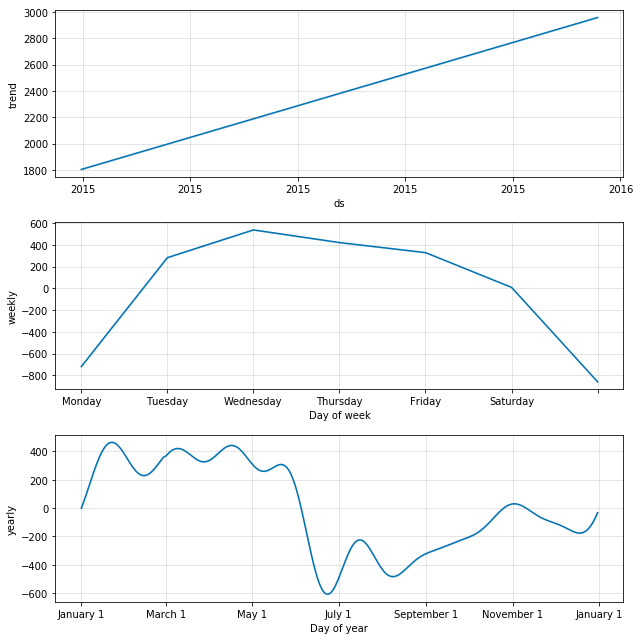

In [13]:
m.plot_components(forecast)

In [14]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 
                                   'yhat_upper']].join(df.set_index('ds'))

In [15]:
import numpy as np
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE = ', round(np.mean(abs(cmp_df[-predictions:]['p'])), 2))
print('MAE = ', round(np.mean(abs(cmp_df[-predictions:]['e'])), 2))

MAPE =  38.38
MAE =  712.86


Оценим качество предсказания по последним 30 точкам.

**Вопрос 2**: Какое получилось MAPE?

**Ответ:** 38.38

**Вопрос 3**: Какое получилось MAE?

**Ответ:** 712.86

## Предсказываем с помощью ARIMA

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
plt.rcParams['figure.figsize'] = (15, 10)

**Вопрос 4:** Проверим стационарность ряда с помощью критерия Дики-Фулера. Является ли ряд стационарным? Какое значение p-value?

Критерий Дики-Фуллера: p=0.107392


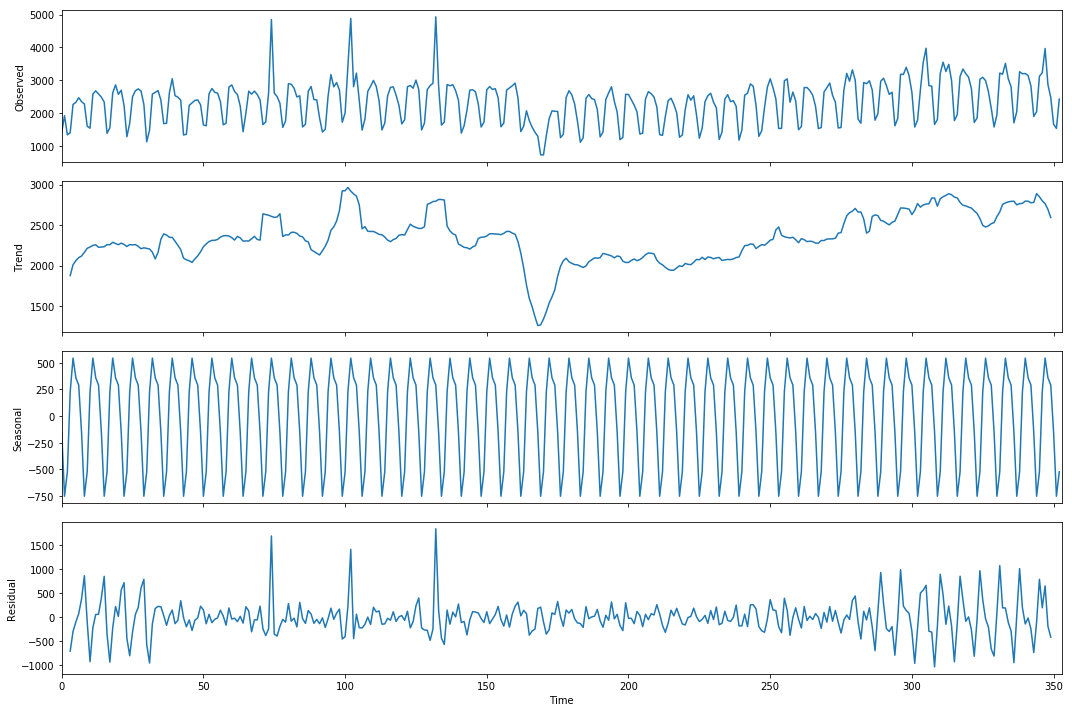

In [17]:
sm.tsa.seasonal_decompose(train_df['y'].values, freq=7).plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df['y'])[1])

А вот сезонно продифференцированный ряд уже будет стационарным.

In [18]:
train_df.set_index('ds', inplace=True)

Критерий Дики-Фуллера: p=0.000000


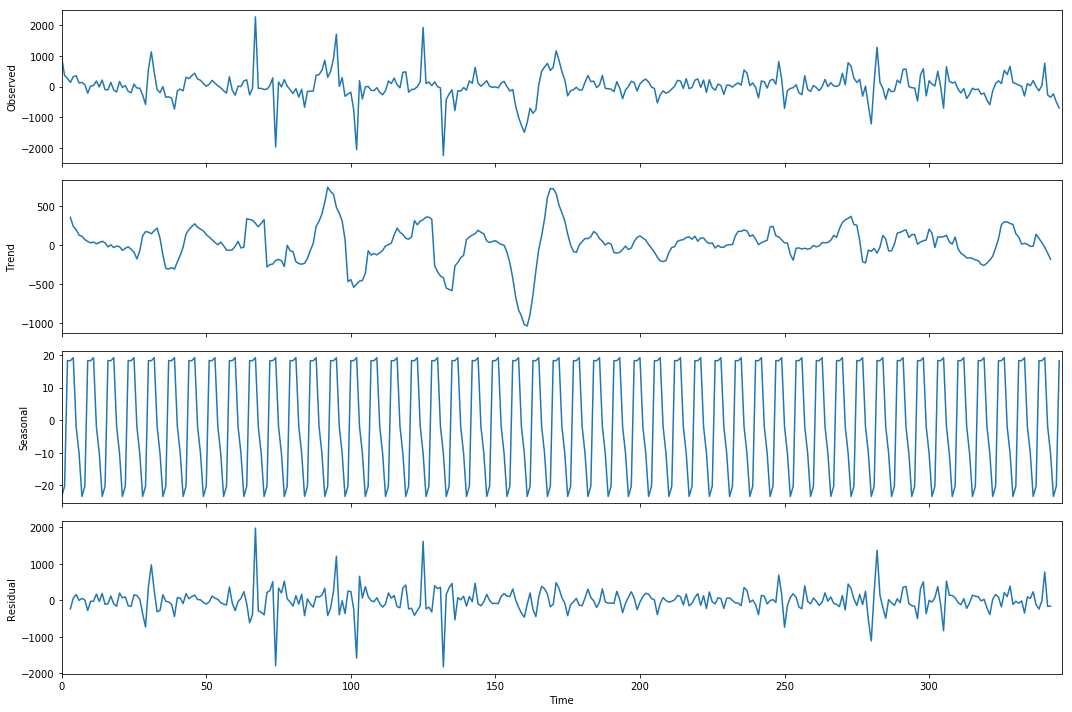

In [19]:
train_df['y_diff'] = train_df.y - train_df.y.shift(7)
sm.tsa.seasonal_decompose(train_df.y_diff[7:].values, freq=7).plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df.y_diff[8:])[1])

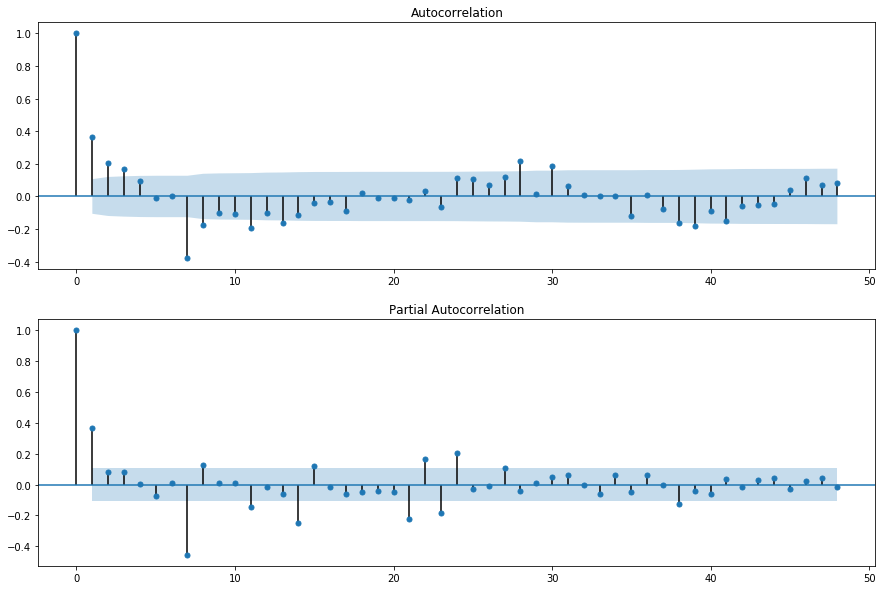

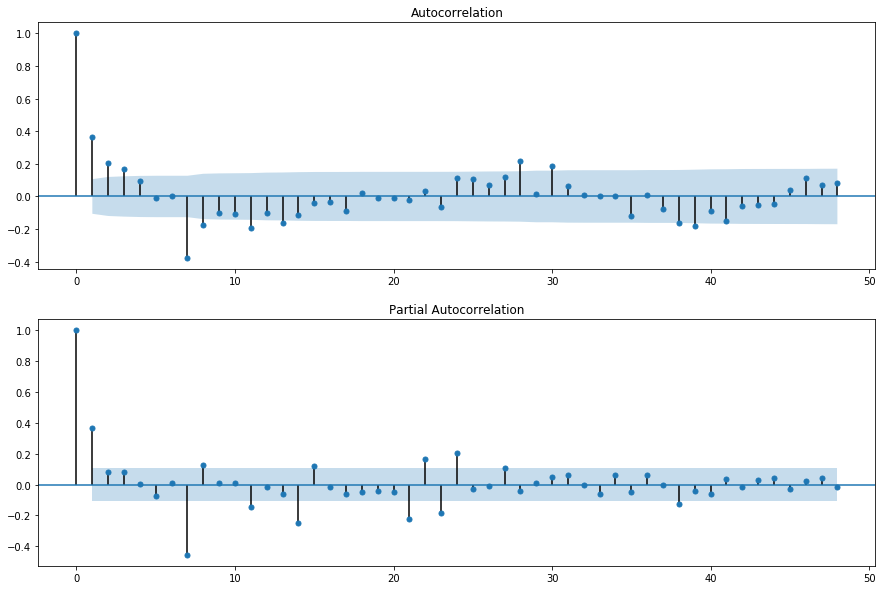

In [20]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(train_df.y_diff[13:].values.squeeze(), lags=48, ax=ax)

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(train_df.y_diff[13:].values.squeeze(), lags=48, ax=ax)

Начальные приближения:
* Q = 1
* q = 3
* P = 3
* p = 1

In [21]:
ps = range(0, 2)
ds = range(0, 2)
qs = range(0, 4)
Ps = range(0, 4)
Ds = range(0, 3)
Qs = range(0, 2)

In [22]:
from itertools import product

parameters = product(ps, ds, qs, Ps, Ds, Qs)
parameters_list = list(parameters)
len(parameters_list)

384

In [23]:
%%time
import warnings
from tqdm import tqdm
results1 = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(train_df['y'], order=(param[0], param[1], param[2]), 
                                        seasonal_order=(param[3], param[4], param[5], 7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except (ValueError, np.linalg.LinAlgError):
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results1.append([param, model.aic])

100%|██████████| 384/384 [04:46<00:00,  1.34it/s]

CPU times: user 12min 14s, sys: 16.1 s, total: 12min 30s
Wall time: 4min 46s


In [24]:
result_table1 = pd.DataFrame(results1)
result_table1.columns = ['parameters', 'aic']
print(result_table1.sort_values(by = 'aic', ascending=True).head())

             parameters          aic
138  (0, 1, 2, 3, 2, 1)  4961.632628
270  (1, 1, 1, 3, 2, 1)  4962.830752
160  (0, 1, 3, 3, 2, 1)  4969.534604
181  (1, 0, 0, 3, 2, 1)  4973.212241
77   (0, 0, 3, 3, 2, 1)  4978.036900


Если рассматривать предложенные в форме варианты:

In [25]:
result_table1[result_table1['parameters'].isin([(1, 0, 2, 3, 1, 0),
                                                (1, 1, 2, 3, 2, 1),
                                                (1, 1, 2, 3, 1, 1),
                                                (1, 0, 2, 3, 0, 0)])]

,parameters,aic
214,"(1, 0, 2, 3, 1, 0)",5022.312524
283,"(1, 1, 2, 3, 1, 1)",5019.555903
285,"(1, 1, 2, 3, 2, 1)",4988.975445


Теперь то же самое, но для ряда с преобразованием Бокса-Кокса.

In [26]:
import scipy.stats
train_df['y_box'], lmbda = scipy.stats.boxcox(train_df['y']) 
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Оптимальный параметр преобразования Бокса-Кокса: 0.732841


In [27]:
results2 = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(train_df['y_box'], order=(param[0], param[1], param[2]), 
                                        seasonal_order=(param[3], param[4], param[5], 7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except (ValueError, np.linalg.LinAlgError):
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results2.append([param, model.aic])
    
warnings.filterwarnings('default')

100%|██████████| 384/384 [03:31<00:00,  1.81it/s]


In [28]:
result_table2 = pd.DataFrame(results2)
result_table2.columns = ['parameters', 'aic']
print(result_table2.sort_values(by = 'aic', ascending=True).head())

             parameters          aic
223  (1, 0, 2, 3, 2, 1)  3528.650843
181  (1, 0, 0, 3, 2, 1)  3530.524249
202  (1, 0, 1, 3, 2, 1)  3532.092281
277  (1, 1, 1, 3, 2, 1)  3534.434780
291  (1, 1, 2, 3, 2, 1)  3534.540192


Если рассматривать предложенные в форме варианты:

In [29]:
result_table2[result_table2['parameters'].isin([(1, 0, 2, 3, 1, 0),
                                                (1, 1, 2, 3, 2, 1),
                                                (1, 1, 2, 3, 1, 1),
                                                (1, 0, 2, 3, 0, 0)])].sort_values(by = 'aic')

,parameters,aic
291,"(1, 1, 2, 3, 2, 1)",3534.540192
220,"(1, 0, 2, 3, 1, 0)",3556.880030
290,"(1, 1, 2, 3, 1, 1)",3557.853184


**Вопрос 5**: Модель SARIMAX c какими параметрами лучшая по AIC-критерию?

**Ответ:** из предложенных вариантов подходят первый (D = 1, d = 0, Q = 0, q = 2, P = 3, p = 1) и второй (D = 2, d = 1, Q = 1, q = 2, P = 3, p = 1) в зависимости от того, делать ли вначале преобразование Бокса-Кокса или нет.

Посмотрим на прогноз лучшей по AIC модели.

In [30]:
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                             y_box   No. Observations:                  353
Model:             SARIMAX(1, 0, 2)x(3, 2, 1, 7)   Log Likelihood               -1756.325
Date:                           Tue, 12 Jun 2018   AIC                           3528.651
Time:                                   23:07:46   BIC                           3559.259
Sample:                                        0   HQIC                          3540.848
                                           - 353                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8191      0.118      6.940      0.000       0.588       1.050
ma.L1         -0.3349      0.124     -2.692

Критерий Стьюдента: p=0.114823
Критерий Дики-Фуллера: p=0.000000


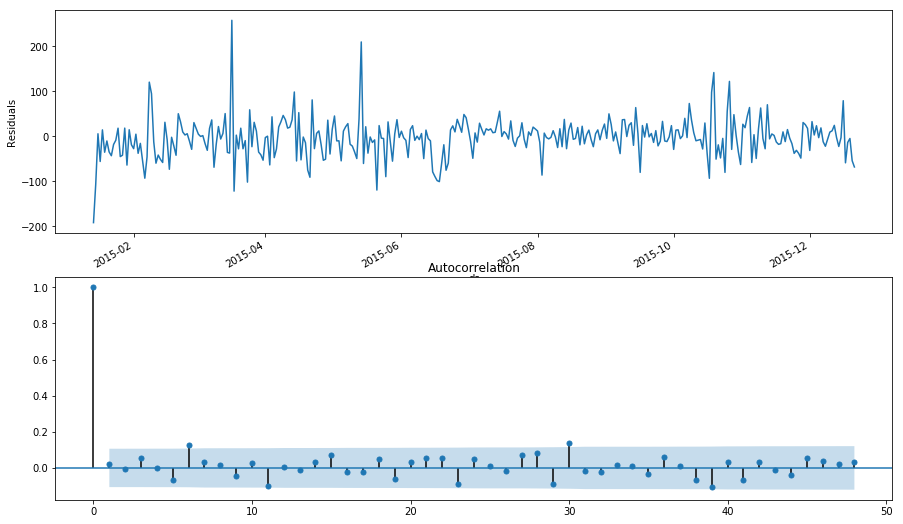

In [31]:
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

In [32]:
def invboxcox(y,lmbda):
    # обратное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda * y + 1) / lmbda))

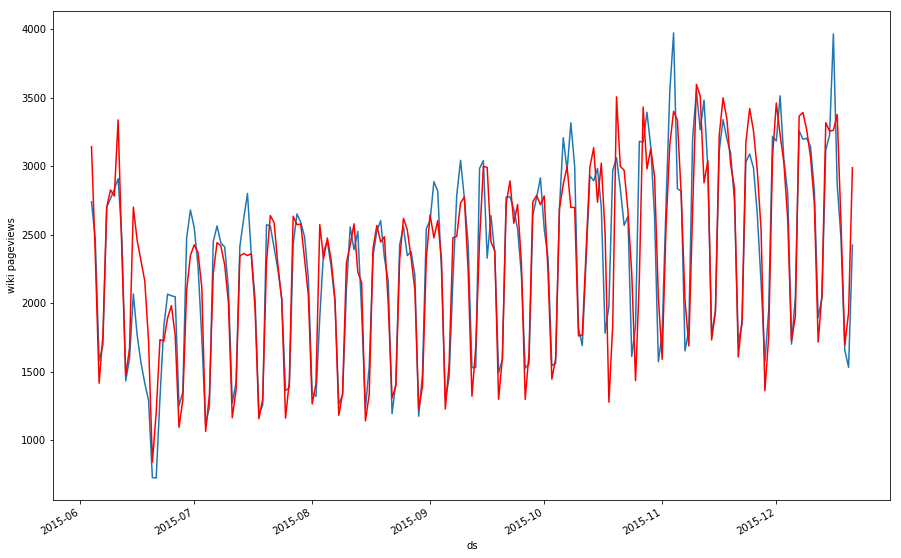

In [33]:
train_df['arima_model'] = invboxcox(best_model.fittedvalues, lmbda)

train_df.y.tail(200).plot()
train_df.arima_model[13:].tail(200).plot(color='r')
plt.ylabel('wiki pageviews');